In [1]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
import statsmodels as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
df = pd.read_csv("LYNXdata.csv", header=0, names=['year', 'trappings'], parse_dates=[0], index_col=0)

In [3]:
my_lynx_ts = pd.Series(df["trappings"].values, 
                       index=pd.DatetimeIndex(
                           data=(tuple(pd.date_range('31/12/1821', periods=114, freq='A-DEC'))),
                           freq='A-DEC'))

In [4]:
my_lynx_ts

1821-12-31     269
1822-12-31     321
1823-12-31     585
1824-12-31     871
1825-12-31    1475
              ... 
1930-12-31     662
1931-12-31    1000
1932-12-31    1590
1933-12-31    2657
1934-12-31    3396
Freq: A-DEC, Length: 114, dtype: int64

In [5]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(timeseries, window):
    rol_mean = timeseries.rolling(window=window).mean()
    rol_std = timeseries.rolling(window=window).std()
    
    # plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='original')
    mean = plt.plot(rol_mean, color='red', label='ROlling mean')
    std = plt.plot(rol_std, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title("rolling mean and standard deviation")
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    timeseries = timeseries.dropna()
    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=["test statistic", 'p-value', "#lags used", 'number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical value {}'.format(k)] = v

    print(dfoutput)
    

/Users/joydeepbhattacharjee/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


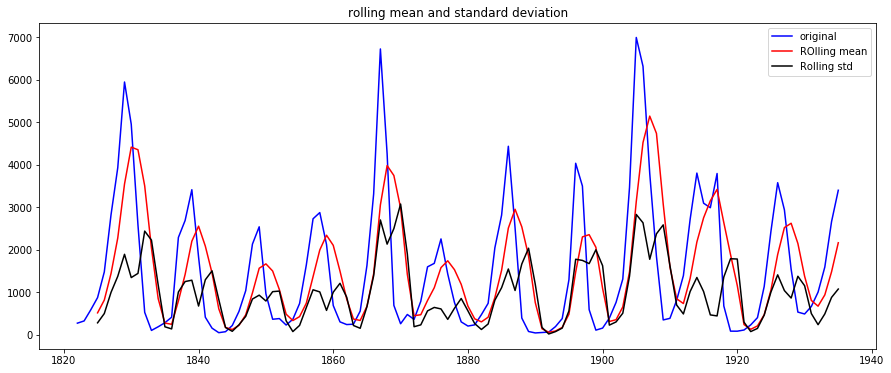

Results of dickey fuller test
test statistic                  -2.996304
p-value                          0.035241
#lags used                       7.000000
number of observations used    106.000000
Critical value 1%               -3.493602
Critical value 5%               -2.889217
Critical value 10%              -2.581533
dtype: float64


In [6]:
test_stationary(my_lynx_ts, 4)

#### the value is significant as the p value is below 0.05

#### stationarity means that we can set the middle parameter d = 0

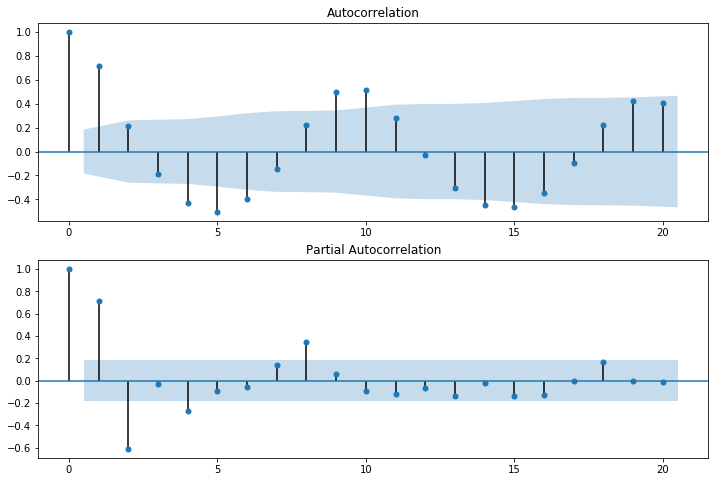

In [7]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(my_lynx_ts, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(my_lynx_ts, lags=20, ax=ax2)

We will start with the PACF plot as there are quite a few points in the ACF plot. we will set the p value to be 2 and then see

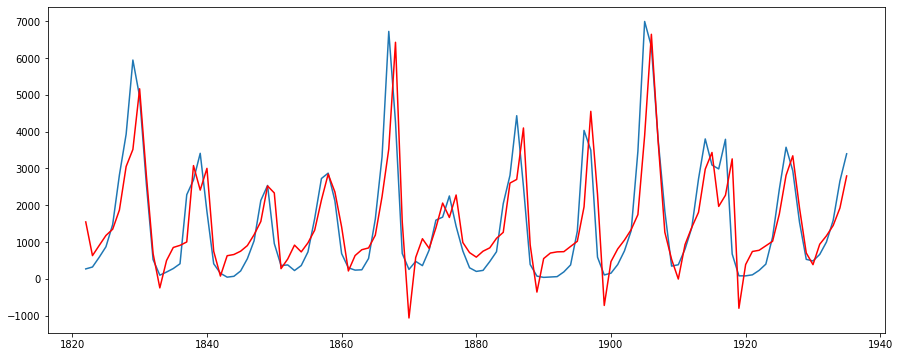

In [8]:
model = ARIMA(my_lynx_ts, order=(2, 0, 0))
results_AR = model.fit()
plt.plot(my_lynx_ts)
plt.plot(results_AR.fittedvalues, color='red')

In [9]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:                     ARMA(2, 0)   Log Likelihood                -935.016
Method:                       css-mle   S.D. of innovations            876.447
Date:                Thu, 16 Jan 2020   AIC                           1878.032
Time:                        17:13:57   BIC                           1888.977
Sample:                    12-31-1821   HQIC                          1882.474
                         - 12-31-1934                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1545.6409    181.672      8.508      0.000    1189.570    1901.712
ar.L1.y        1.1474      0.074     15.459      0.000       1.002       1.293
ar.L2.y       -0.5998      0.074     -8.110      0.000      -0.745      -0.455
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9566           -0.8673j            1.2913           -0.1172
AR.2            0.9566           +0.8673j            1.2913            0.1172
-----------------------------------------------------------------------------
"""

### ACF on residuals of the model

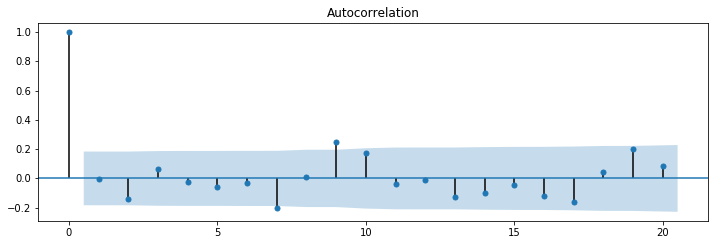

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR.resid, lags=20, ax=ax1)

There is significance in lags 7, 9 and probably 19. If it shows significance in the first bar itself it means that the model needs readjustment. But at the end of ACF plots, it could be a chance as well and hence we can try adjustment

### histogram of the residuals

Text(0.5, 1.0, 'Residuals 2, 0, 0 vs Normal distribution mean = -5.22, std = 882.2')

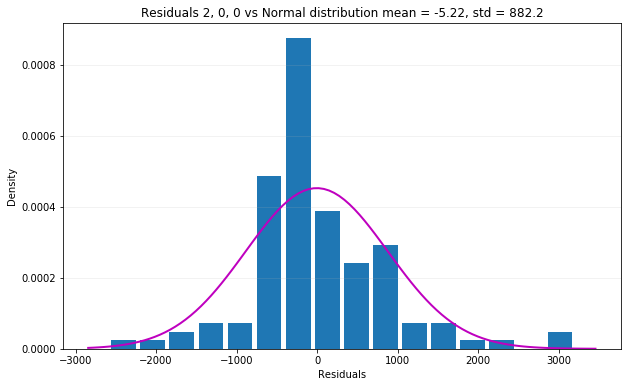

In [11]:
from scipy.stats import norm

plt.figure(figsize=(10, 6))
plt.hist(results_AR.resid, bins='auto', density=True, rwidth=0.85, label='Residuals') # density true normal dist line curve
mu, std = norm.fit(results_AR.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals 2, 0, 0 vs Normal distribution mean = ' + str(round(mu, 2)) + ', std = ' + str(round(std, 2)))

 ### trying an AR 4 model


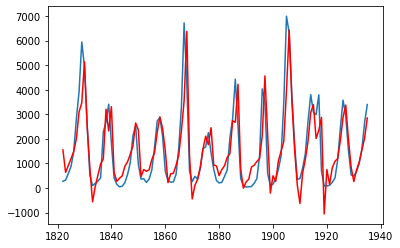

In [12]:
model = ARIMA(my_lynx_ts, order=(4, 0, 0))
results_AR = model.fit()
plt.plot(my_lynx_ts)
plt.plot(results_AR.fittedvalues, color='red')

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  114
Model:                     ARMA(4, 0)   Log Likelihood                -931.111
Method:                       css-mle   S.D. of innovations            845.949
Date:                Thu, 16 Jan 2020   AIC                           1874.222
Time:                        17:13:57   BIC                           1890.639
Sample:                    12-31-1821   HQIC                          1880.885
                         - 12-31-1934                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1547.5904    136.851     11.309      0.000    1279.367    1815.814
ar.L1.y        1.1246      0.090     12.450      0.000       0.948       1.302
ar.L2.y       -0.7174      0.137     -5.250      0.0

Text(0.5, 1.0, 'Residuals 2, 0, 0 vs Normal distribution mean = -9.16, std = 852.15')

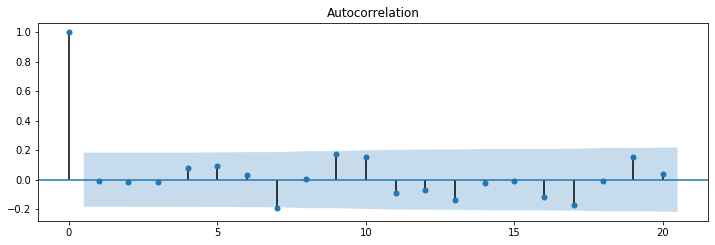

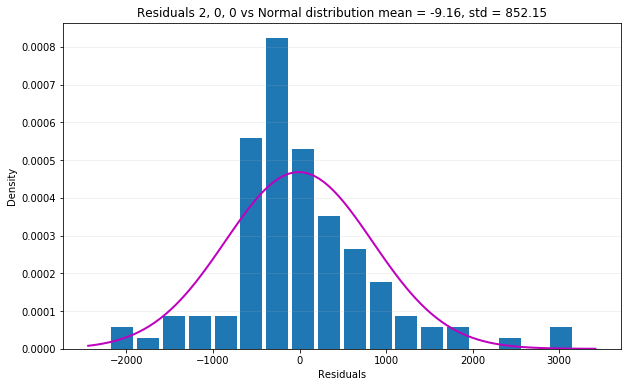

In [13]:
# model summary
print(results_AR.summary())

# acf on residuals of the model
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR.resid, lags=20, ax=ax1)

# histogram of the residuals
from scipy.stats import norm

plt.figure(figsize=(10, 6))
plt.hist(results_AR.resid, bins='auto', density=True, rwidth=0.85, label='Residuals') # density true normal dist line curve
mu, std = norm.fit(results_AR.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals 2, 0, 0 vs Normal distribution mean = ' + str(round(mu, 2)) + ', std = ' + str(round(std, 2)))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  114
Model:                     ARMA(4, 1)   Log Likelihood                -930.675
Method:                       css-mle   S.D. of innovations            842.600
Date:                Thu, 16 Jan 2020   AIC                           1875.351
Time:                        17:13:58   BIC                           1894.504
Sample:                    12-31-1821   HQIC                          1883.124
                         - 12-31-1934                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1547.6493    124.674     12.414      0.000    1303.292    1792.007
ar.L1.y        1.3613      0.226      6.032      0.000       0.919       1.804
ar.L2.y       -0.9883      0.271     -3.645      0.0

Text(0.5, 1.0, 'Residuals 2, 0, 0 vs Normal distribution mean = -9.83, std = 848.85')

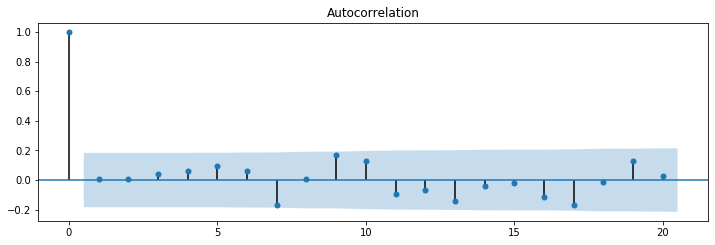

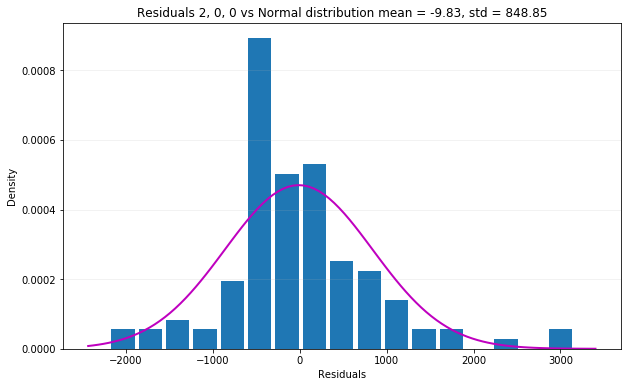

In [14]:
model = ARIMA(my_lynx_ts, order=(4, 0, 1))
results_AR = model.fit()
plt.plot(my_lynx_ts)
plt.plot(results_AR.fittedvalues, color='red')


# model summary
print(results_AR.summary())

# acf on residuals of the model
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR.resid, lags=20, ax=ax1)

# histogram of the residuals
from scipy.stats import norm

plt.figure(figsize=(10, 6))
plt.hist(results_AR.resid, bins='auto', density=True, rwidth=0.85, label='Residuals') # density true normal dist line curve
mu, std = norm.fit(results_AR.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals 2, 0, 0 vs Normal distribution mean = ' + str(round(mu, 2)) + ', std = ' + str(round(std, 2)))

### checking the results

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  114
Model:                     ARMA(2, 0)   Log Likelihood                -935.016
Method:                       css-mle   S.D. of innovations            876.447
Date:                Thu, 16 Jan 2020   AIC                           1878.032
Time:                        17:13:59   BIC                           1888.977
Sample:                    12-31-1821   HQIC                          1882.474
                         - 12-31-1934                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1545.6409    181.672      8.508      0.000    1189.570    1901.712
ar.L1.y        1.1474      0.074     15.459      0.000       1.002       1.293
ar.L2.y       -0.5998      0.074     -8.110      0.0

Text(0.5, 1.0, 'Residuals 2, 0, 0 vs Normal distribution mean = -5.22, std = 882.2')

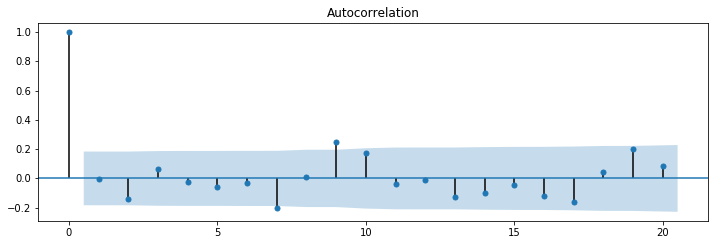

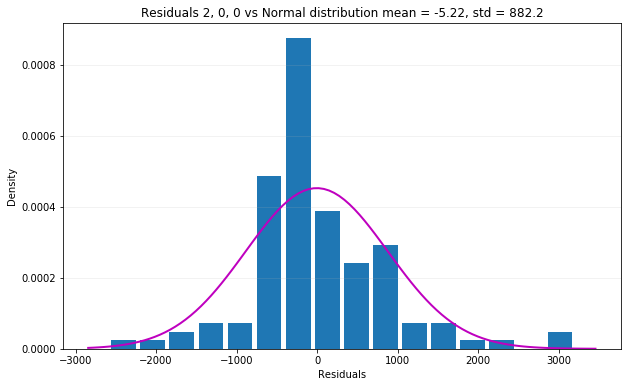

In [15]:
model_ar2 = ARIMA(my_lynx_ts, order=(2, 0, 0))
results_AR2 = model_ar2.fit()
plt.plot(my_lynx_ts)
plt.plot(results_AR2.fittedvalues, color='red')


# model summary
print(results_AR2.summary())

# acf on residuals of the model
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR2.resid, lags=20, ax=ax1)

# histogram of the residuals
from scipy.stats import norm

plt.figure(figsize=(10, 6))
plt.hist(results_AR2.resid, bins='auto', density=True, rwidth=0.85, label='Residuals') # density true normal dist line curve
mu, std = norm.fit(results_AR2.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals 2, 0, 0 vs Normal distribution mean = ' + str(round(mu, 2)) + ', std = ' + str(round(std, 2)))

In [16]:
my_lynx_ts.tail()

1930-12-31     662
1931-12-31    1000
1932-12-31    1590
1933-12-31    2657
1934-12-31    3396
Freq: A-DEC, dtype: int64

In [17]:
results_AR2.fittedvalues.tail()

1930-12-31     938.353100
1931-12-31    1167.838759
1932-12-31    1449.516843
1933-12-31    1923.789345
1934-12-31    2794.252472
Freq: A-DEC, dtype: float64

In [18]:
results_AR2.resid.tail()

1930-12-31   -276.353100
1931-12-31   -167.838759
1932-12-31    140.483157
1933-12-31    733.210655
1934-12-31    601.747528
Freq: A-DEC, dtype: float64

Equations

$y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2} + \epsilon_t$

actual equation for the ARIMA is:

$y_t - \mu = \phi_1(y_{t-1} - \mu) + \phi_2(y_{t-2} - \mu) + \epsilon_t$

In [19]:
3396 - 1545.6409

1850.3591

In [20]:
1.1474 * (2657 - 1545.6409) - 0.5998 * (1590 - 1545.6409) + 601.747528

1850.3143711599996

### making predictions

In [21]:
model_AR4 = ARIMA(my_lynx_ts, order=(4, 0, 0))
results_AR4 = model_AR4.fit()

In [22]:
forecast_400 = results_AR4.predict(start='31/12/1935', end='31/12/1945')

In [23]:
forecast_400

1935-12-31    2980.900458
1936-12-31    2114.902733
1937-12-31    1362.045235
1938-12-31     839.347158
1939-12-31     669.086679
1940-12-31     874.543701
1941-12-31    1281.549293
1942-12-31    1679.974918
1943-12-31    1933.485737
1944-12-31    1987.707157
1945-12-31    1868.245503
Freq: A-DEC, dtype: float64

In [24]:
model_AR202 = ARIMA(my_lynx_ts, order=(2, 0, 2))
results_AR202 = model_AR202.fit()

In [25]:
forecast_202 = results_AR202.predict(start='31/12/1935', end='31/12/1945')

#### visualising the forecasts

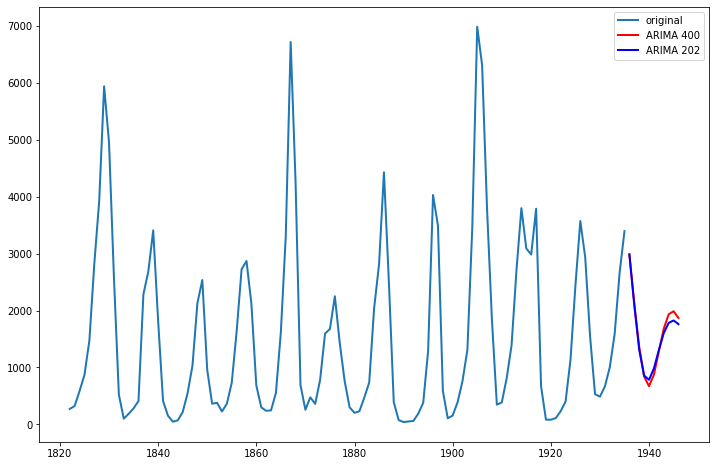

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(my_lynx_ts, linewidth=2, label="original")
plt.plot(forecast_400, linewidth=2, color='red', label="ARIMA 400")
plt.plot(forecast_202, linewidth=2, color='blue', label="ARIMA 202")
plt.legend()